# CCPA domain generation

This notebook generates lat lon grids, elevation, and land mask for CCPA data.

In [2]:
# ------------------------------------------------------- #
# system tools
import sys
import time
from glob import glob
from datetime import datetime, timedelta

# ------------------------------------------------------- #
# data tools
import h5py
import pygrib
import numpy as np
import netCDF4 as nc

# ------------------------------------------------------- #
# Interpolation tools
#from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import scipy.interpolate as spint
from scipy.spatial import Delaunay
import itertools

# ------------------------------------------------------- #
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

## Helper functions

In [4]:
# def interp_weights(xy, uv, d=2):
#     tri = Delaunay(xy)
#     simplex = tri.find_simplex(uv)
#     vertices = np.take(tri.simplices, simplex, axis=0)
#     temp = np.take(tri.transform, simplex, axis=0)
#     delta = uv - temp[:, d]
#     bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
#     return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

# def interpolate(values, vtx, wts):
#     return np.einsum('nj,nj->n', np.take(values, vtx), wts)

## Get CCPA 1/8 degree lat lons from grib

In [5]:
# filename = sorted(glob(camp_dir+'wget_CCPA/ccpa.20030101/12/*06h*'))

# with pygrib.open(filename[0]) as grbio:
#     lat, lon = grbio[1].latlons()
#     apcp = grbio[1].values

# lon[:, -1] = lon[:, -1] - 360

# tuple_save = (lon, lat)
# label_save = ['lon_CCPA', 'lat_CCPA']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CCPA_domain.hdf')

## Interpolate ETOPO1 to CCPA grids

In [10]:
# with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
#     lon_CCPA = h5io['lon_CCPA'][...]
#     lat_CCPA = h5io['lat_CCPA'][...]

In [12]:
# with nc.Dataset(camp_dir+'BACKUP/ETOPO1_Ice_g_gmt4.grd', 'r') as ncio:
#     x = ncio['x'][2500:7400]
#     y = ncio['y'][6500:9000]
#     z = ncio['z'][6500:9000, 2500:7400]

# long, lat = np.meshgrid(x, y)
# long = np.array(long)
# lat = np.array(lat)

In [13]:
# # Computed once and for all
# vtx, wts = interp_weights(np.vstack([long.ravel(), lat.ravel()]).T, 
#                           np.vstack([lon_CCPA.ravel(), lat_CCPA.ravel()]).T)

In [14]:
# elev_CCPA_temp = interpolate(z.ravel(), vtx, wts)
# elev_CCPA_temp = elev_CCPA_temp.reshape(lon_CCPA.shape)
# elev_CCPA = np.copy(elev_CCPA_temp)
# elev_CCPA[elev_CCPA<0] = 0

## Get CCPA land mask

**Load old land mask from my HRRR project**

In [ ]:
# with h5py.File(NCAR_dir+'HRRR_domain.hdf', 'r') as h5io:
#     land_mask_3km = h5io['land_mask_3km'][...]
#     lon_3km = h5io['lon_3km'][...]
#     lat_3km = h5io['lat_3km'][...]

In [19]:
# # Computed once and for all
# vtx, wts = interp_weights(np.vstack([lon_3km.ravel(), lat_3km.ravel()]).T, 
#                           np.vstack([lon_CCPA.ravel(), lat_CCPA.ravel()]).T)

In [20]:
# mask_CCPA_temp = interpolate(land_mask_3km.ravel(), vtx, wts)
# mask_CCPA_temp = mask_CCPA_temp.reshape(lon_CCPA.shape)
# land_mask_CCPA = np.copy(mask_CCPA_temp)
# #elev_CCPA[elev_CCPA<0] = 0

In [23]:
# land_mask_CCPA[land_mask_CCPA>0.5] = 1.0
# land_mask_CCPA[land_mask_CCPA<1.0] = 0.0

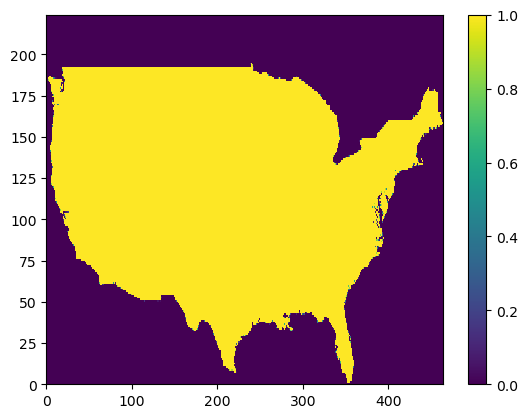

In [22]:
# plt.pcolormesh(land_mask_CCPA)
# plt.colorbar()

## A mask for the US states

In [6]:
import united_states

In [ ]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    lon_CCPA = h5io['lon_CCPA'][...]
    lat_CCPA = h5io['lat_CCPA'][...]
    elev_CCPA = h5io['elev_CCPA'][...]
    land_mask_CCPA = h5io['land_mask_CCPA'][...]

In [7]:
def str_search(strs, keys, verbose=True):
    '''
    Return the index of each keys element from strs
    e.g.
        strs = ['a', 'b', 'c', 'd']; keys = ['a', 'c']
        str_serach(...) --> [0, 2]
    '''
    ind = []
    for key in keys:
        ind_temp = [i for i,s in enumerate(strs) if key in s]
        if len(ind_temp) == 1:
            ind.append(ind_temp[0])
        elif len(ind_temp) > 1:
            if verbose:
                print('duplicate items (will pick the last one):')
            for ind_d in ind_temp:
                if verbose:
                    print('{} --> {}'.format(ind_d, strs[ind_d]))
            ind.append(ind_d)
        else:
            if verbose:
                print('item {} not found.'.format(key))
            ind.append(9999)
    return ind

In [8]:
state_names = [
    'Alabama',
    'Arizona',
    'Arkansas',
    'California',
    'Colorado',
    'Connecticut',
    'Delaware',
    'Florida',
    'Georgia',
    'Idaho',
    'Illinois',
    'Indiana',
    'Iowa',
    'Kansas',
    'Kentucky',
    'Louisiana',
    'Maine',
    'Maryland',
    'Massachusetts',
    'Michigan',
    'Minnesota',
    'Mississippi',
    'Missouri',
    'Montana',
    'Nebraska',
    'Nevada',
    'New Hampshire',
    'New Jersey',
    'New Mexico',
    'New York',
    'North Carolina',
    'North Dakota',
    'Ohio',
    'Oklahoma',
    'Oregon',
    'Pennsylvania',
    'Rhode Island',
    'South Carolina',
    'South Dakota',
    'Tennessee',
    'Texas',
    'Utah',
    'Vermont',
    'Virginia',
    'Washington',
    'West Virginia',
    'Wisconsin',
    'Wyoming']

In [9]:
us = united_states.UnitedStates()

In [10]:
# Replace ' ' with '_', so it is one unique string 

state_names_match = []

for name in state_names:
    state_names_match.append(name.replace(" ", "_"))

**Identify which state each grid cell belongs to**

In [51]:
# shape_ccpa = lon_CCPA.shape
# state_id = np.empty(shape_ccpa)
# state_id[...] = np.nan

# for i in range(shape_ccpa[0]):
#     for j in range(shape_ccpa[1]):
#         result = us.from_coords(lat_CCPA[i, j], lon_CCPA[i, j])
#         if len(result) > 0:
#             name = result[0].name
#             name = name.replace(" ", "_")
#             if name == 'Virginia':
#                 state_id[i, j] = 43
#             elif name == 'West_Virginia':
#                 state_id[i, j] = 45
#             else:
#                 state_id[i, j] = str_search(state_names_match, [name,])[0]

# tuple_save = (lon_CCPA, lat_CCPA, elev_CCPA, land_mask_CCPA, state_id)
# label_save = ['lon_CCPA', 'lat_CCPA', 'elev_CCPA', 'land_mask_CCPA', 'state_id']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CCPA_domain_backup.hdf')

In [66]:
with h5py.File(save_dir+'CCPA_domain_backup.hdf', 'r') as h5io:
    state_id = h5io['state_id'][...]
    lon_CCPA = h5io['lon_CCPA'][...]
    lat_CCPA = h5io['lat_CCPA'][...]
    elev_CCPA = h5io['elev_CCPA'][...]
    land_mask_CCPA = h5io['land_mask_CCPA'][...]

#state_id[98:100, 360:400] = 43
state_id[state_id==9999] = np.nan
state_id[land_mask_CCPA==0] = np.nan

state_id[69, 176:175+69] = 40
state_id[70, 244:270] = 2

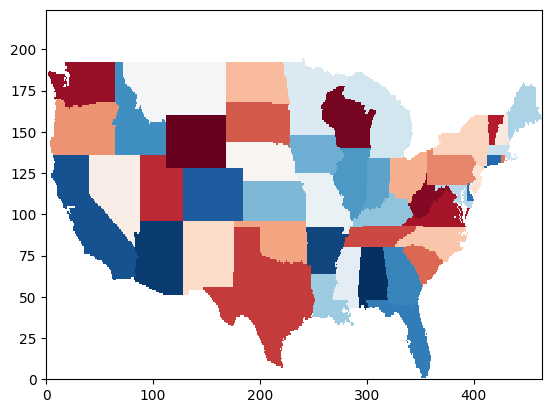

In [67]:
plt.pcolormesh(state_id, cmap=plt.cm.RdBu_r)

## Save everything

In [1]:
# tuple_save = (lon_CCPA, lat_CCPA, elev_CCPA, land_mask_CCPA, state_id)
# label_save = ['lon_CCPA', 'lat_CCPA', 'elev_CCPA', 'land_mask_CCPA', 'state_id']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CCPA_domain.hdf')